smart_hans_08022022_194751_7_250-281_08_gny_.csv
smart_hans_08022022_192131_8_280-310_08_wny_.csv
smart_hans_08022022_190823_13_429-460_08_mny_person_hat_nicht_auf_huf_geschaut.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_08022022_182746_7_242-273_08_wny_.csv
smart_hans_08022022_184110_5_176-207_08_mgy_.csv
smart_hans_07312022_185231_4_153-182_08_mny_.csv
smart_hans_07312022_174011_10_330-358_08_mny_.csv
smart_hans_08022022_192219_4_154-184_08_wny_person_hat_nach_12_gewackelt.csv
smart_hans_08022022_191248_9_307-336_08_mny_.csv
smart_hans_08022022_205208_8_276-308_08_wnn_.csv
smart_hans_08022022_191134_12_403-433_08_mny_.csv
smart_hans_08022022_185137_12_400-430_08_mny_.csv
smart_hans_08022022_172713_13_435-465_08_mgn_.csv
smart_hans_08022022_211022_9_314-345_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_08022022_184808_8_276-305_08_mny_.csv
smart_hans_08022022_195222_3_123-154_08_gny_.csv
smart_hans_080220

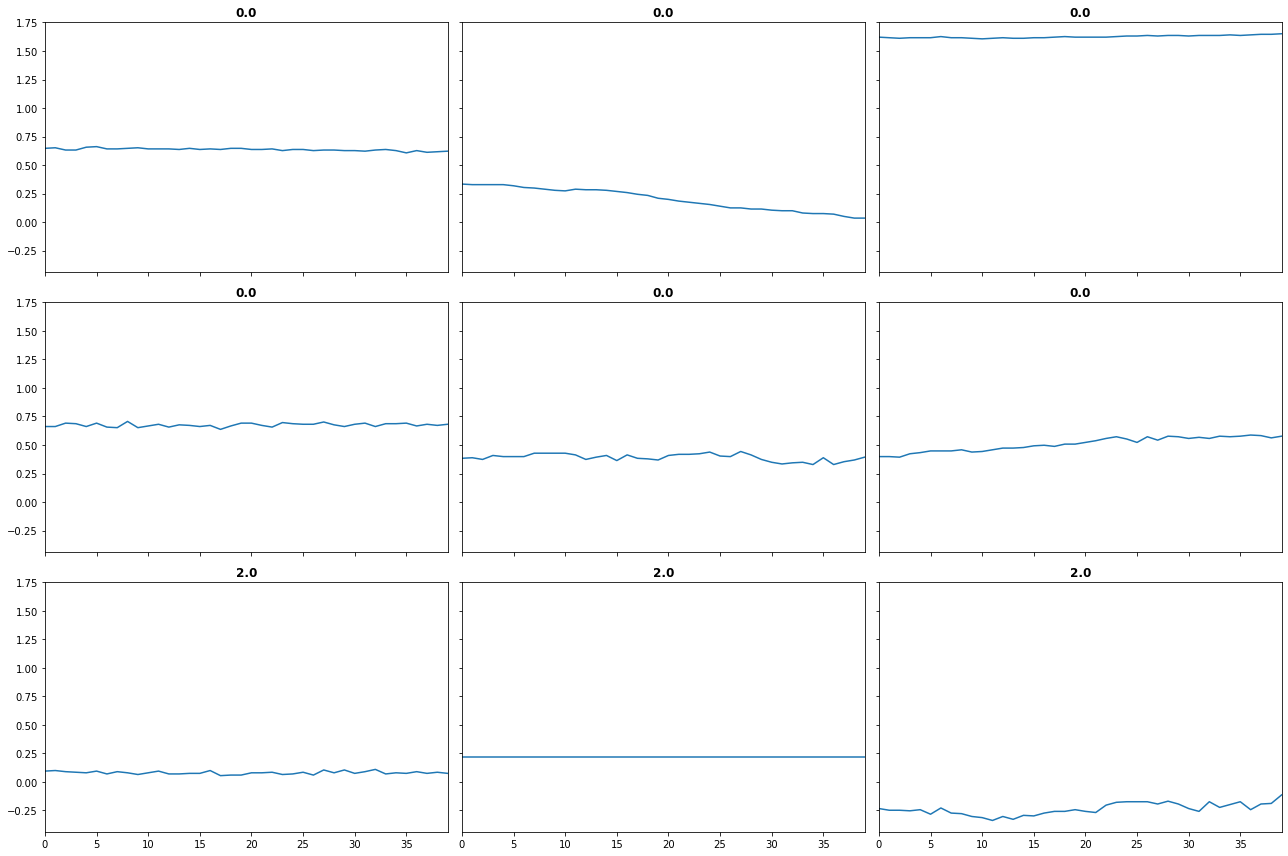

In [56]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1

num_scenario = 1
model_to_use = "InceptionTimePlus"
learning_cycles = 20
features_to_learn_with = ["nosetip_y"]
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="/Users/adi/Nextcloud/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=1, move_window_by=-10, feature_list=features_to_learn_with)
train, test= dl.get_train_test(frac = 0.8, seed = 0)

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

dls.show_batch(sharey=True)

In [57]:

scenario_name_stage0 = save_name+"_stage0"
model = InceptionTime(dls.vars, dls.c)
learn = ts_learner(dls, model, metrics=accuracy, train_metrics=True)
learn.save(scenario_name_stage0)

Path('models/scenario_1_InceptionTimePlus_stage0.pth')

SuggestedLRs(valley=0.0005754399462603033)

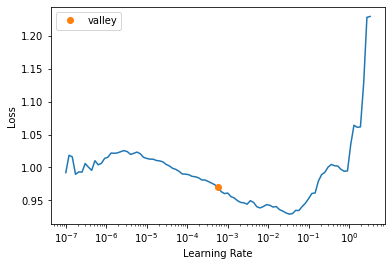

In [58]:
learn.load(scenario_name_stage0)
learn.lr_find()

In [59]:
scenario_name_stage1 = scenario_name_stage0.replace("0","1")
learn.fit_one_cycle(learning_cycles, lr_max=1e-3)
learn.save(scenario_name_stage1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.922431,0.547414,0.937991,0.561290,00:07
1,0.892169,0.541487,0.905913,0.537634,00:06
2,0.885377,0.547414,0.894600,0.565591,00:06
3,0.878111,0.553879,0.919262,0.569892,00:06
4,0.869547,0.560884,0.859709,0.546237,00:06
5,0.867525,0.550647,0.914650,0.544086,00:06
6,0.862007,0.551724,0.995974,0.565591,00:06
7,0.860632,0.560884,0.862752,0.552688,00:06
8,0.859417,0.563578,0.862837,0.531183,00:06
9,0.854155,0.564655,0.910715,0.546237,00:06


Path('models/scenario_1_InceptionTimePlus_stage1.pth')

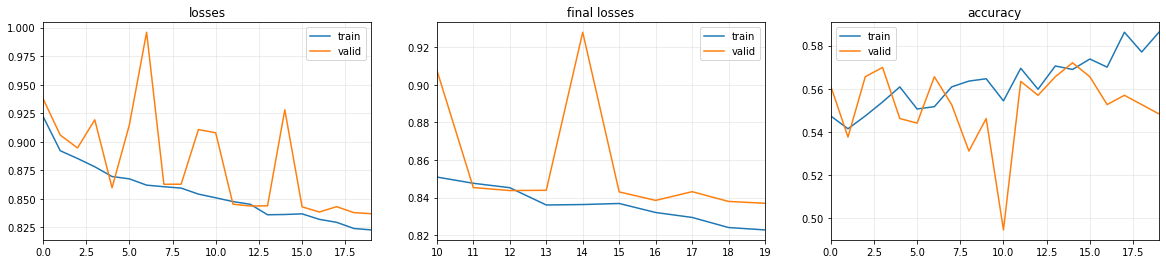

In [60]:
learn.recorder.plot_metrics()

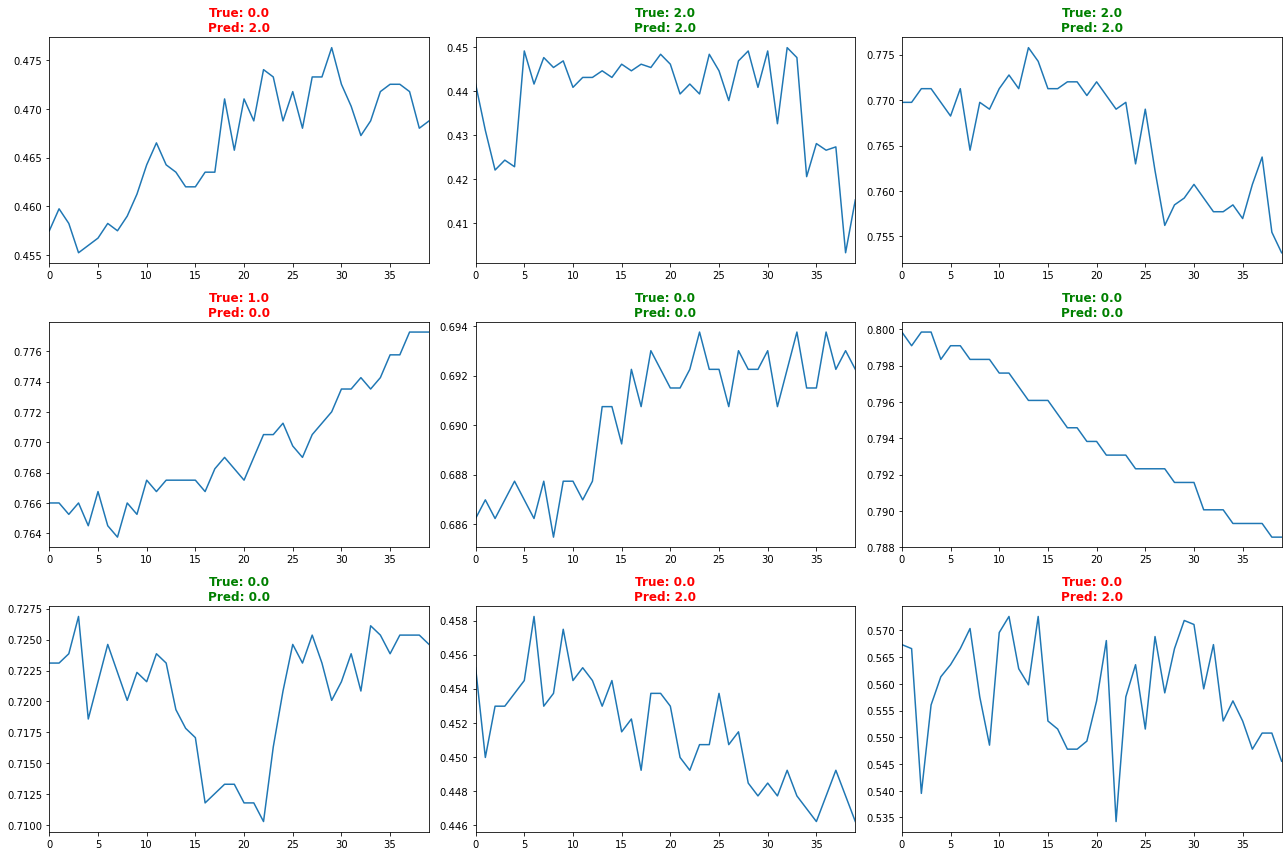

In [61]:
learn.show_results()

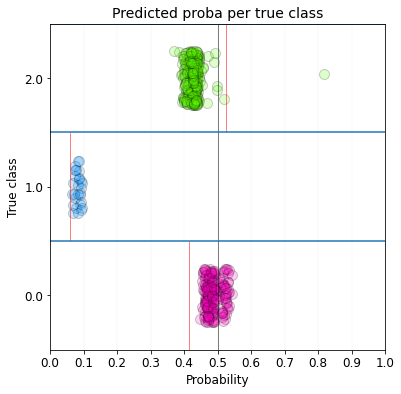

In [62]:
learn.show_probas()
#was sagt probability aus? accuracy vs probability?

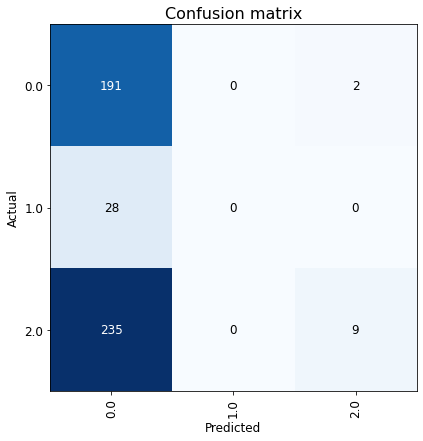

In [63]:
learn.plot_confusion_matrix()
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = "confusion_matrix_"+save_name+"_features_{}_learning_cycles_{}_{}.png".format(feature_list_string,learning_cycles, current_time)
plt.savefig(plot_name, ext='png', bbox_inches="tight")

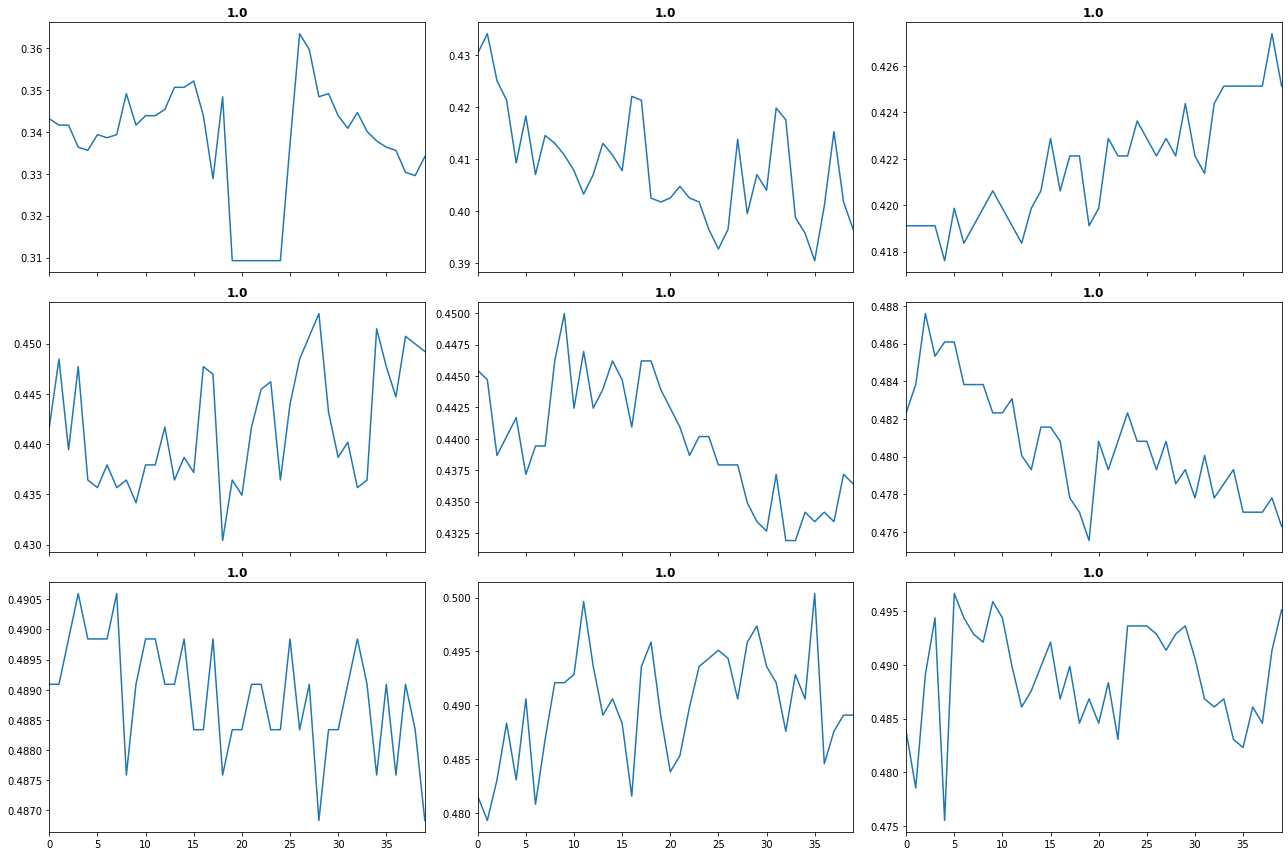

In [64]:
learn.plot_top_losses(X[splits[1]], y[splits[1]], largest=True)